### Trying to understand condition-specific regulator clusters
#### (1) Is it because regulators or downstream genes are only expressed in one/some conditions?
#### (2) Is this mainly a quantitative effect: quantitative change in expression alters power and/or regulatory connections become stronger

In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage
from scipy.stats import ttest_rel
from statannotations.Annotator import Annotator
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'NimbusSanL'

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [3]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data'

In [4]:
adata_de = sc.read_h5ad(datadir + f'/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed='r')
adata_final = sc.read_h5ad(datadir + '/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')
de_summary_stats = pd.read_csv(datadir + '/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
de_summary_stats.baseMean = de_summary_stats.baseMean.fillna(0)
de_summary_stats = de_summary_stats.set_index('obs_names')
downstream_gene_df = pd.read_csv(datadir + '/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)

In [5]:
downstream_gene_df = pd.read_csv(datadir + '/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)

In [6]:
cluster_df = pd.read_csv('./results/nde75ntotal50_cluster_specificity.csv', index_col=0)
mask = ((cluster_df.cluster_gene_size>5) & (cluster_df.corr_max>0.1)) | ((cluster_df.cluster_gene_size>=4) & (cluster_df.corr_max>0.3)) 
cluster_df_filtered = cluster_df[mask].copy()

custom_order = ['Rest', 'Rest_Stim8hr', 'Stim8hr', 'Stim8hr_Stim48hr', 'Stim48hr', 'across_condition']
cluster_df_filtered['condition_specificity'] = pd.Categorical(
    cluster_df_filtered['condition_specificity'],
    categories=custom_order,
    ordered=True
)
cluster_df_filtered = cluster_df_filtered.sort_values(by='condition_specificity')

## Check regulator expression across clusters

In [7]:
all_gene = set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
all_gene = list(all_gene)

all_gene_baseMean_df = pd.DataFrame(index=all_gene)
all_gene_baseMean_df.loc[all_gene, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean

df = all_gene_baseMean_df.copy()

rest = df['baseMean_Rest']
stim8 = df['baseMean_Stim8hr']
stim48 = df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest_all = log_stim8 - log_rest
stim48_rest_all = log_stim48 - log_rest
stim48_stim8_all = log_stim48 - log_stim8

### Overall regulator expression difference

In [8]:
df_exp = pd.DataFrame(index=adata_final.obs['hdbscan'].unique().tolist())
for cl in adata_final.obs['hdbscan'].unique():
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].unique().tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]

    regulator_baseMean_df = pd.DataFrame(index=regulator)
    regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[regulator].baseMean

    df = regulator_baseMean_df.copy()

    rest = df['baseMean_Rest']
    stim8 = df['baseMean_Stim8hr']
    stim48 = df['baseMean_Stim48hr']
    
    log_rest = np.log1p(rest)
    log_stim8 = np.log1p(stim8)
    log_stim48 = np.log1p(stim48)
    
    stim8_rest = log_stim8 - log_rest
    stim48_rest = log_stim48 - log_rest
    stim48_stim8 = log_stim48 - log_stim8
    
    t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
    t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
    t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)

    df_exp.loc[cl, 'regulator_stim8_rest_diff'] = np.mean(stim8_rest) - np.mean(stim8_rest_all)
    df_exp.loc[cl, 'regulator_stim48_rest_diff'] = np.mean(stim48_rest) - np.mean(stim48_rest_all)
    df_exp.loc[cl, 'regulator_stim48_stim8_diff'] = np.mean(stim48_stim8) - np.mean(stim48_stim8_all)
    df_exp.loc[cl, 'regulator_stim8_rest_p'] = p_value1
    df_exp.loc[cl, 'regulator_stim48_rest_p'] = p_value2
    df_exp.loc[cl, 'regulator_stim48_stim8_p'] = p_value3
df_exp['regulator_stim8_rest_diff'] = df_exp['regulator_stim8_rest_diff'].fillna(0)
df_exp['regulator_stim48_rest_diff'] = df_exp['regulator_stim48_rest_diff'].fillna(0)
df_exp['regulator_stim48_stim8_diff'] = df_exp['regulator_stim48_stim8_diff'].fillna(0)
df_exp['regulator_stim8_rest_p'] = df_exp['regulator_stim8_rest_p'].fillna(1)
df_exp['regulator_stim48_rest_p'] = df_exp['regulator_stim48_rest_p'].fillna(1)
df_exp['regulator_stim48_stim8_p'] = df_exp['regulator_stim48_stim8_p'].fillna(1)

# Multiple test correction
df_exp['regulator_stim8_rest_fdr'] = multipletests(df_exp['regulator_stim8_rest_p'])[1]
df_exp['regulator_stim48_rest_fdr'] = multipletests(df_exp['regulator_stim48_rest_p'])[1]
df_exp['regulator_stim48_stim8_fdr'] = multipletests(df_exp['regulator_stim48_stim8_p'])[1]

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [9]:
cluster_order = cluster_df_filtered.index.tolist()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_74221/2872954235.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fail_mask_annot = (~fail_mask).applymap(convert_to_star)


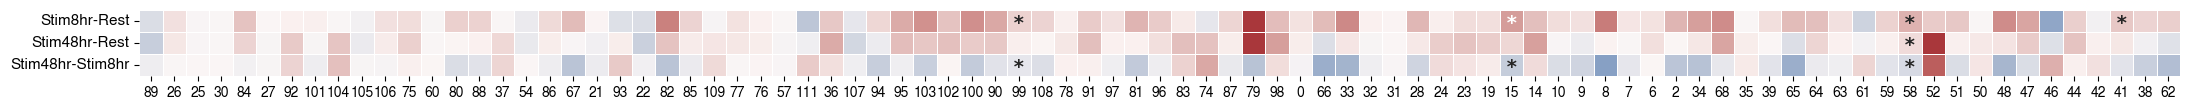

In [10]:
fail_mask = (df_exp[['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]>0.05)
fail_mask = fail_mask.rename(columns={'regulator_stim8_rest_fdr': 'regulator_stim8_rest_diff',
                                      'regulator_stim48_rest_fdr': 'regulator_stim48_rest_diff',
                                      'regulator_stim48_stim8_fdr': 'regulator_stim48_stim8_diff'})

def convert_to_star(val):
    if val:
        return '*'
    else:
        return ''

fail_mask_annot = (~fail_mask).applymap(convert_to_star)

thres = 1
fig, ax = plt.subplots(figsize=(22, 1.2))
annot_kws = {"fontsize": 14, 'ha': 'center', 'va': 'center_baseline', 'weight': 'bold', 'fontfamily': 'monospace'}
sns.heatmap(df_exp.loc[cluster_order, ['regulator_stim8_rest_diff', 'regulator_stim48_rest_diff', 'regulator_stim48_stim8_diff']].T,
            vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='vlag', cbar=False, annot=fail_mask_annot.loc[cluster_order].T, fmt='', 
            yticklabels=['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], annot_kws=annot_kws)
ax.set_yticklabels(['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=10, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('results/cluster_by_condition/regulator_exp_all_regulators.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

### Plot colormap

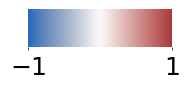

In [48]:
thres = 1
orientation = 'bottom'
colormap = 'vlag'
cmap = sns.color_palette(colormap, as_cmap=True)
norm = mpl.colors.Normalize(vmin=-thres, vmax=thres)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(2, 1))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=18, width=0.5, length=2)
cb.set_ticks([-thres, thres])
#cb.set_ticklabels(['0.1', '0.5'])

cb.ax.xaxis.set_ticks_position(orientation)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_'+str(thres)+orientation+'_'+colormap+'.png', dpi=600, bbox_inches='tight', pad_inches=0)

### Individual cluster regulator expression

In [11]:
cl = 27

regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].unique().tolist()

# (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
regulator = [item for item in regulator if item in adata_de.var_names]

regulator_baseMean_df = pd.DataFrame(index=regulator)
regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[regulator].baseMean
regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[regulator].baseMean
regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[regulator].baseMean

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_40446/3001937057.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=20)


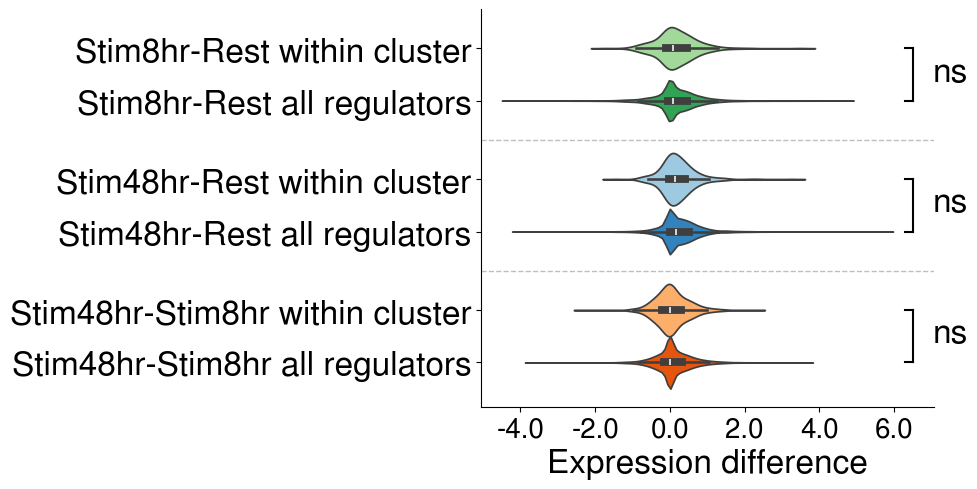

In [167]:
rest = regulator_baseMean_df['baseMean_Rest']
stim8 = regulator_baseMean_df['baseMean_Stim8hr']
stim48 = regulator_baseMean_df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest = log_stim8 - log_rest
stim48_rest = log_stim48 - log_rest
stim48_stim8 = log_stim48 - log_stim8

p_value1, p_value2, p_value3 = df_exp.loc[cl, ['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]

# Parse into DataFrame
data_frames_to_concat = [
    # Stim8hr vs Rest Comparison
    pd.DataFrame({'Value': stim8_rest, 'Comparison': 'stim8_rest', 'Set': 'within cluster'}),
    pd.DataFrame({'Value': stim8_rest_all, 'Comparison': 'stim8_rest', 'Set': 'all regulators'}),
    pd.DataFrame({'Value': stim48_rest, 'Comparison': 'stim48_rest', 'Set': 'within cluster'}),
    pd.DataFrame({'Value': stim48_rest_all, 'Comparison': 'stim48_rest', 'Set': 'all regulators'}),
    pd.DataFrame({'Value': stim48_stim8, 'Comparison': 'stim48_stim8', 'Set': 'within cluster'}),
    pd.DataFrame({'Value': stim48_stim8_all, 'Comparison': 'stim48_stim8', 'Set': 'all regulators'}),
]

df = pd.concat(data_frames_to_concat, ignore_index=True)

# Plot violinplot
fig, ax = plt.subplots(figsize=(10, 5))
vp = sns.violinplot(data=df, x='Value', y='Comparison', hue='Set', ax=ax)
for i, collection in enumerate(vp.collections):
    collection.set_facecolor(colors[i])
ax.get_legend().remove()

# Plot significance
def get_sig_text(p_val):
    if p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'ns'

y_positions = [-0.2, 0.2, 0.8, 1.2, 1.8, 2.2]
x_position = 6.5
line_x_offset = 0.2
ax.plot([x_position, x_position], [y_positions[0], y_positions[1]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[0], y_positions[0]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[1], y_positions[1]], color='black', linewidth=1.5)
ax.text(x_position + 1, y_positions[0]+0.3, f'{get_sig_text(p_value1)}', 
        ha='center', va='bottom', fontsize=24)

ax.plot([x_position, x_position], [y_positions[2], y_positions[3]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[2], y_positions[2]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[3], y_positions[3]], color='black', linewidth=1.5)
ax.text(x_position + 1, y_positions[2]+0.3, f'{get_sig_text(p_value2)}', 
        ha='center', va='bottom', fontsize=24)

line_x3 = 6
ax.plot([x_position, x_position], [y_positions[4], y_positions[5]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[4], y_positions[4]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[5], y_positions[5]], color='black', linewidth=1.5)
ax.text(x_position + 1, y_positions[4]+0.3, f'{get_sig_text(p_value3)}', 
        ha='center', va='bottom', fontsize=24)


ax.set_yticks(y_positions)
ax.set_yticklabels(['Stim8hr-Rest within cluster', 'Stim8hr-Rest all regulators',
                   'Stim48hr-Rest within cluster', 'Stim48hr-Rest all regulators', 
                   'Stim48hr-Stim8hr within cluster', 'Stim48hr-Stim8hr all regulators'], fontsize=24)

ax.set_xticklabels(ax.get_xticks(), fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xlabel('Expression difference', fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('results/cluster_by_condition/cluster'+str(cl)+'regulator_exp.pdf', dpi=600,
           bbox_inches='tight', pad_inches=0)